## Imports

In [2]:
import json
import numpy as np
import matplotlib.pyplot as plt
import random

In [3]:
file = open('results.json')
results = json.load(file)

In [4]:
results.keys()

dict_keys(['frame_dir', 'total_frames', 'label', 'filename_tmpl', 'modality', 'start_index', 'frame_inds', 'clip_len', 'frame_interval', 'num_clips', 'imgs', 'original_shape', 'img_shape', 'scale_factor', 'keep_ratio', 'written'])

In [4]:
results['original_shape']

[128, 171]

In [5]:
results['img_shape']

[128, 171]

In [5]:
imgs_array = results['imgs']

In [6]:
imgs = np.array(imgs_array)
imgs.shape

(16, 128, 171, 3)

In [7]:
img = imgs[0]

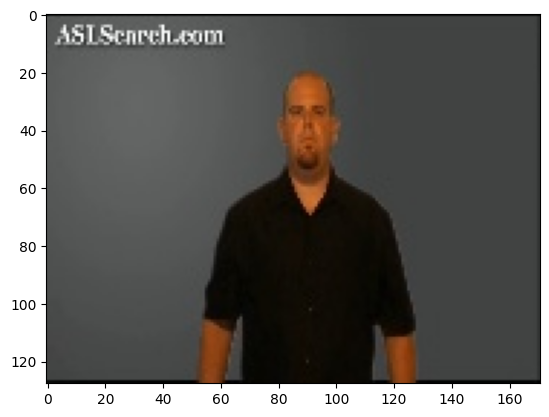

In [8]:
plt.imshow(img)

# Mixup


In [6]:
file = open('mixup.json')
mixup = json.load(file)

In [8]:
mixup.keys()

dict_keys(['mixed_imgs', 'mixed_label'])

In [20]:
mixed_imgs = np.array(mixup['mixed_imgs'])

In [16]:
mixed_labels = np.array(mixup['mixed_label'])

In [22]:
# (B, N, C, T, H, W) 
mixed_imgs.shape

(8, 1, 3, 32, 224, 224)

In [18]:
mixed_labels.shape

(8, 1, 100)

In [46]:
imgs = mixed_imgs[1][0]
imgs.shape

(3, 32, 224, 224)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


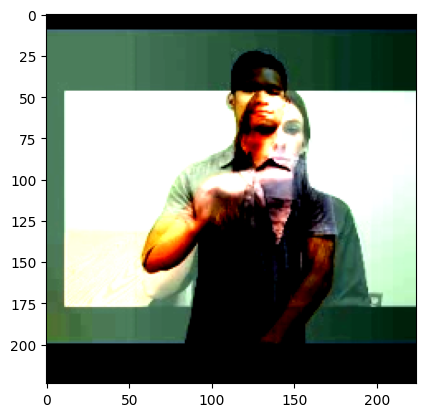

In [47]:
# NHWC
imgs = imgs.transpose([1,2,3,0])
plt.imshow(imgs[6])

# RandAug_T

In [9]:
type(img[0][0][0])

numpy.int64

In [10]:
import numpy as np
import random
import PIL, PIL.ImageOps, PIL.ImageEnhance, PIL.ImageDraw
from PIL import Image


def temporal_interpolate(v_list, t, n):
    if len(v_list) == 1:
        return v_list[0]
    elif len(v_list) == 2:
        return v_list[0] + (v_list[1] - v_list[0]) * t / n
    else:
        NotImplementedError('Invalid degree')


class Augment:
    def __init__(self):
        pass

    def __call__(self, buffer):
        raise NotImplementedError

    def ShearX(self, imgs, v_list):  # [-0.3, 0.3]
        for v in v_list:
            assert -0.3 <= v <= 0.3
        if random.random() > 0.5:
            v_list = [-v for v in v_list]

        out = [img.transform(img.size, PIL.Image.Transform.AFFINE, (1, temporal_interpolate(v_list, t, len(imgs) - 1), 0, 0, 1, 0)) for t, img in enumerate(imgs)]
        return out

    def ShearY(self, imgs, v_list):  # [-0.3, 0.3]
        for v in v_list:
            assert -0.3 <= v <= 0.3
        if random.random() > 0.5:
            v_list = [-v for v in v_list]

        out = [img.transform(img.size, PIL.Image.Transform.AFFINE, (1, 0, 0, temporal_interpolate(v_list, t, len(imgs) - 1), 1, 0)) for t, img in enumerate(imgs)]
        return out

    def TranslateX(self, imgs, v_list):  # [-150, 150] => percentage: [-0.45, 0.45]
        for v in v_list:
            assert -0.45 <= v <= 0.45
        if random.random() > 0.5:
            v_list = [-v for v in v_list]
        v_list = [v * imgs.size[1] for v in v_list]

        out = [img.transform(img.size, PIL.Image.Transform.AFFINE, (1, 0, temporal_interpolate(v_list, t, len(imgs) - 1), 0, 1, 0)) for t, img in enumerate(imgs)]
        return out

    def TranslateXabs(self, imgs, v_list):  # [-150, 150] => percentage: [-0.45, 0.45]
        for v in v_list:
            assert 0 <= v
        if random.random() > 0.5:
            v_list = [-v for v in v_list]

        out = [img.transform(img.size, PIL.Image.Transform.AFFINE, (1, 0, temporal_interpolate(v_list, t, len(imgs) - 1), 0, 1, 0)) for t, img in enumerate(imgs)]
        return out

    def TranslateY(self, imgs, v_list):  # [-150, 150] => percentage: [-0.45, 0.45]
        for v in v_list:
            assert -0.45 <= v <= 0.45
        if random.random() > 0.5:
            v_list = [-v for v in v_list]
        v_list = [v * imgs.size[2] for v in v_list]

        out = [img.transform(img.size, PIL.Image.Transform.AFFINE, (1, 0, 0, 0, 1, temporal_interpolate(v_list, t, len(imgs) - 1))) for t, img in enumerate(imgs)]
        return out

    def TranslateYabs(self, imgs, v_list):  # [-150, 150] => percentage: [-0.45, 0.45]
        for v in v_list:
            assert 0 <= v
        if random.random() > 0.5:
            v_list = [-v for v in v_list]

        out = [img.transform(img.size, PIL.Image.Transform.AFFINE, (1, 0, 0, 0, 1, temporal_interpolate(v_list, t, len(imgs) - 1))) for t, img in enumerate(imgs)]
        return out

    def Rotate(self, imgs, v_list):  # [-30, 30]
        for v in v_list:
            assert -30 <= v <= 30
        if random.random() > 0.5:
            v_list = [-v for v in v_list]

        out = [img.rotate(temporal_interpolate(v_list, t, len(imgs) - 1)) for t, img in enumerate(imgs)]
        return out

    def AutoContrast(self, imgs, _):
        out = [PIL.ImageOps.autocontrast(img) for img in imgs]
        return out

    def Invert(self, imgs, _):
        out = [PIL.ImageOps.invert(img) for img in imgs]
        return out

    def Equalize(self, imgs, _):
        out = [PIL.ImageOps.equalize(img) for img in imgs]
        return out

    def Flip(self, imgs, _):  # not from the paper
        out = [PIL.ImageOps.mirror(img) for img in imgs]
        return out

    def Solarize(self, imgs, v_list):  # [0, 256]
        for v in v_list:
            assert 0 <= v <= 256

        out = [PIL.ImageOps.solarize(img, temporal_interpolate(v_list, t, len(imgs) - 1)) for t, img in enumerate(imgs)]
        return out

    def Posterize(self, imgs, v_list):  # [4, 8]
        v_list = [max(1, int(v)) for v in v_list]
        v_list = [max(1, int(v)) for v in v_list]

        out = [PIL.ImageOps.posterize(img, int(temporal_interpolate(v_list, t, len(imgs) - 1))) for t, img in enumerate(imgs)]
        return out

    def Contrast(self, imgs, v_list):  # [0.1,1.9]
        for v in v_list:
            assert 0.1 <= v <= 1.9

        out = [PIL.ImageEnhance.Contrast(img).enhance(temporal_interpolate(v_list, t, len(imgs) - 1)) for t, img in enumerate(imgs)]
        return out

    def Color(self, imgs, v_list):  # [0.1,1.9]
        for v in v_list:
            assert 0.1 <= v <= 1.9

        out = [PIL.ImageEnhance.Color(img).enhance(temporal_interpolate(v_list, t, len(imgs) - 1)) for t, img in enumerate(imgs)]
        return out

    def Brightness(self, imgs, v_list):  # [0.1,1.9]
        for v in v_list:
            assert 0.1 <= v <= 1.9

        out = [PIL.ImageEnhance.Brightness(img).enhance(temporal_interpolate(v_list, t, len(imgs) - 1)) for t, img in enumerate(imgs)]
        return out

    def Sharpness(self, imgs, v_list):  # [0.1,1.9]
        for v in v_list:
            assert 0.1 <= v <= 1.9

        out = [PIL.ImageEnhance.Sharpness(img).enhance(temporal_interpolate(v_list, t, len(imgs) - 1)) for t, img in enumerate(imgs)]
        return out

    def Identity(self, imgs, _):
        return imgs

    def augment_list(self):
        # list of data augmentations and their ranges
        l = [
            (self.Identity, 0, 1),
            (self.AutoContrast, 0, 1),
            (self.Equalize, 0, 1),
            (self.Invert, 0, 1),
            (self.Rotate, 0, 30),
            (self.Posterize, 0, 4),
            (self.Solarize, 0, 256),
            (self.Color, 0.1, 1.9),
            (self.Contrast, 0.1, 1.9),
            (self.Brightness, 0.1, 1.9),
            (self.Sharpness, 0.1, 1.9),
            (self.ShearX, 0., 0.3),
            (self.ShearY, 0., 0.3),
            (self.TranslateXabs, 0., 100),
            (self.TranslateYabs, 0., 100),
        ]

        return l


class RandAugment(Augment):
    def __init__(self, n=2, m=7, temp_degree=1, range=1.0):
        super(RandAugment, self).__init__()
        self.max_severity = 30
        self.temp_degree = temp_degree
        self.n = n
        self.m = m  # usually values in the range [5, 30] is best
        self.range = range
        self.augment_list = self.augment_list()

    def __call__(self, results):
        buffer = [Image.fromarray(img.astype('uint8')) for img in np.array(results['imgs'])]

        ops = random.choices(self.augment_list, k=self.n)
        for op, minval, maxval in ops:
            if self.temp_degree == 0:
                val_list = [(float(self.m) / self.max_severity) * float(maxval - minval) + minval]
            else: # temp_degree == 1
                tval = float(np.random.uniform(low=0.0, high=0.5 * self.range * self.m))
                if random.random() > 0.5:
                    val_list = [((float(self.m) - tval) / self.max_severity) * float(maxval - minval) + minval]
                    val_list.extend([((float(self.m) + tval) / self.max_severity) * float(maxval - minval) + minval])
                else:
                    val_list = [((float(self.m) + tval) / self.max_severity) * float(maxval - minval) + minval]
                    val_list.extend([((float(self.m) - tval) / self.max_severity) * float(maxval - minval) + minval])
            print(val_list)
            buffer = op(buffer, val_list)

        results['imgs'] = np.array([np.array(img, np.dtype('int64')) for img in buffer])

        return results

In [11]:
randaug = RandAugment(2,8)

[0.2023384405982384, 0.33099489273509497]
[0.5343170094025339, 0.625682990597466]


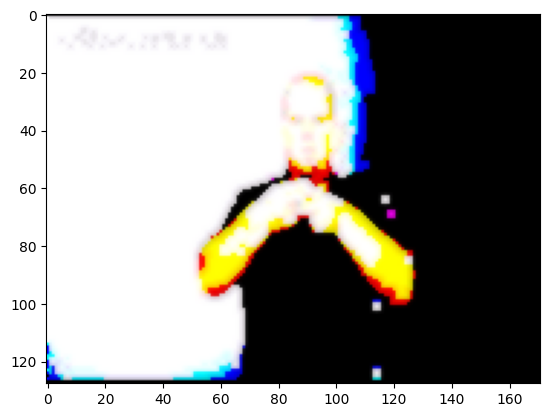

In [16]:
out_imgs = randaug.__call__(results)
plt.imshow(results['imgs'][15])

## CutOut

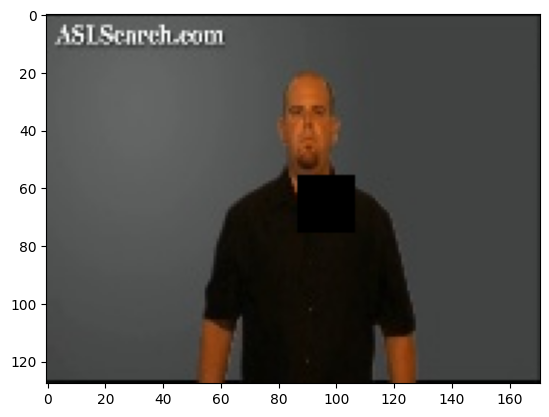

In [14]:
imgs = np.array(imgs_array)
box_size = 20
assert box_size < imgs.shape[1]
box_h, box_w = random.randint(0, imgs.shape[1]-box_size), random.randint(0, imgs.shape[2]-box_size)
imgs[:, box_h:box_h+box_size, box_w:box_w+box_size, :] = 0
results['imgs'] = imgs.tolist()
plt.imshow(results['imgs'][0])

## Horizontal Flip


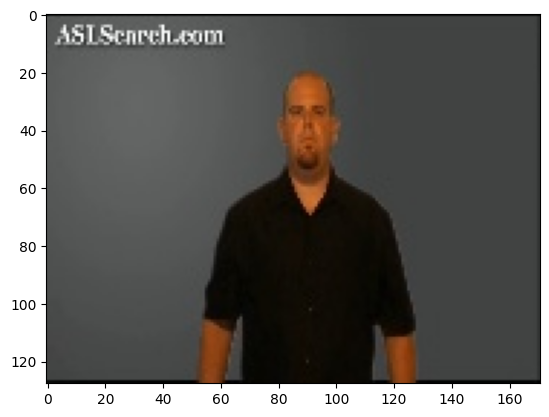

In [15]:
plt.imshow(img)

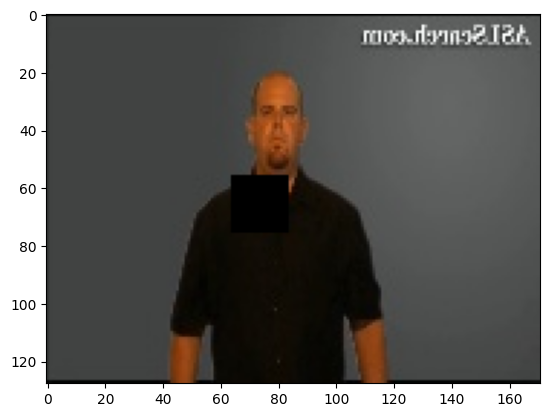

In [16]:
p = 0.5
if random.random() < p:
    imgs = np.array(results['imgs'])
    results['imgs'] = list(np.flip(imgs, axis=2))
plt.imshow(results['imgs'][0])

## Temporal Flip

In [17]:
imgs.shape

(16, 128, 171, 3)

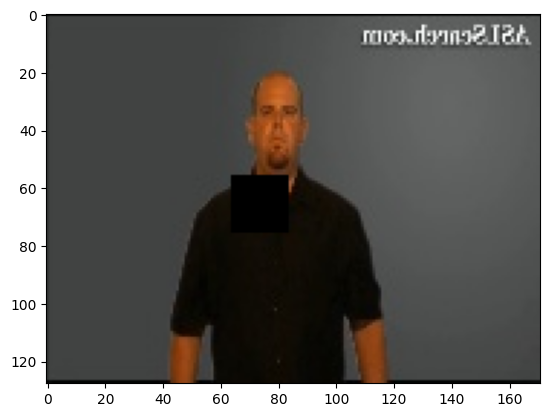

In [18]:
p = 0.5
if random.random() < p:
    imgs = np.array(results['imgs'])
    results['imgs'] = list(np.flip(imgs, axis=0))
plt.imshow(results['imgs'][0])

In [19]:
imgs.shape

(16, 128, 171, 3)

In [20]:
imgs.transpose([0,3,2,1]).shape

(16, 3, 171, 128)